In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.special import softmax
from scipy.spatial.distance import euclidean
import biomart


import umap
import pickle
import scipy.spatial as sp
import seaborn as sns
import itertools

from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import load_iris

from scipy.spatial.distance import pdist,squareform
from scipy.cluster import hierarchy

import glob

In [71]:
reprog_paths = pd.read_csv("direct_reprogramming_recipes.csv")
reprog_facts = []
_=[[reprog_facts.append(y) for y in x.split(",")] for x in reprog_paths.factors.values]
reprog_facts=np.unique(reprog_facts)
inv_mapping = pickle.load(open('inv_mapping.pickle','rb'))
mapping = pickle.load(open('mapping.pickle','rb'))
annotations = pd.read_csv("annotations_facs2.csv").set_index('cell')
metadata = pd.read_csv("metadata_FACS2.csv")
tfs = pd.read_csv("mouse_ensemble_tfs_from_lambertetal_isyes.unique.txt",names=["geneId",]).set_index("geneId")
rel_ctypes = [
          'Bergmann glial cell',
          'Brush cell of epithelium proper of large intestine',
          'Kupffer cell',
          'astrocyte',
          'basal cell', 
          'basal cell of epidermis', 
          'basophil', 
          'bladder cell',
          'bladder urothelial cell', 
          'brain pericyte',
          'cardiac muscle cell',
          'ciliated columnar cell of tracheobronchial tree', 
          'endocardial cell',
          'endothelial cell of hepatic sinusoid',
          'enterocyte of epithelium of large intestine', 
          'enteroendocrine cell',
          'epidermal cell', 
          'epithelial cell of large intestine', 
          'epithelial cell of lung',
          'epithelial cell of proximal tubule', 
          'erythrocyte', 
          'fibroblast',
          'hepatocyte',
          'B cell', 'T cell',
          'natural killer cell',
          'keratinocyte',
          'kidney collecting duct epithelial cell',
          'large intestine goblet cell',
          'luminal epithelial cell of mammary gland', 
          'lung endothelial cell',
          'macrophage',
          'mesenchymal cell',
          'microglial cell', 
          'monocyte', 
          'myofibroblast cell',
          'neuron', 
          'oligodendrocyte',
          'pancreatic A cell',
          'pancreatic D cell', 
          'pancreatic PP cell', 
          'pancreatic acinar cell',
          'pancreatic ductal cell', 
          'pancreatic stellate cell',
          'professional antigen presenting cell', 
          'skeletal muscle satellite cell', 
          'smooth muscle cell', 
          'stromal cell',
          'type B pancreatic cell']

/var/folders/97/_bppr_xn34v9xtss08ljc1840000gn/T/ipykernel_19473/3855634498.py:7: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  annotations = pd.read_csv("annotations_facs2.csv").set_index('cell')


In [72]:
intestine_and_liver_cells = [
    "epithelial cell of large intestine",
    "large intestine goblet cell",
    "Brush cell of epithelium proper of large intestine",
    "enterocyte of epithelium of large intestine",
    "enteroendocrine cell",
    "hepatocyte",
    "endothelial cell of hepatic sinusoid",
    "Kupffer cell"
]

In [73]:
def initialize_ctypes():
    def load_tabmuris_data(fs):
        total_data_tfs = []
        for f in fs:
            data =pd.read_csv(f,index_col=0)
            new_idx_tfs = []
            for x in data.index:
                if x in inv_mapping.keys() and inv_mapping[x] in tfs.index:
                    new_idx_tfs.append(x)
                elif x in ["Spi1","Lmo2"]:
                    new_idx_tfs.append(x)
            data_tfs = data.loc[new_idx_tfs].T
            total_data_tfs.append(data_tfs)
        total_data_tfs = pd.concat(total_data_tfs)
        return total_data_tfs

    def gen_ctype_lst(dataset):
        lst = []
        ctypes = []
        for j in dataset.index:
            lst.append(j in annotations.index)
            if lst[-1]:
                ctypes.append(annotations.loc[j].cell_ontology_class)
        return ctypes,lst
    
    def load_and_generate_avgd_by_celltypes():

        total_data_tfs = load_tabmuris_data(glob.glob("FACS/*"))
        ctypes,lst = gen_ctype_lst(total_data_tfs)
        total_data_tfs = total_data_tfs[lst]
        avgd_by_ctype = total_data_tfs.groupby(ctypes).mean()
        avgd_by_ctype.to_csv("avgd_by_ctype.csv")
    
    load_and_generate_avgd_by_celltypes()
        
def load_ctype_patterns():
    avgd_by_ctype = pd.read_csv("avgd_by_ctype.csv",index_col=0)
    return avgd_by_ctype

def preprocess_ctype_patterns(patterns):
    df = np.log1p(patterns)
    rel_tfs = list(set(list(df.columns[(df.max()>0) & (df.mean()>np.log1p(3)) & (df.std()>np.log1p(3))].values)  + list(reprog_facts)))
    #df=patterns
    df = df.loc[:,rel_tfs]
    return df

In [74]:
# initialize_ctypes()

In [77]:
gene_profiles = preprocess_ctype_patterns(load_ctype_patterns())

In [60]:
gene_profiles = gene_profiles.loc[intestine_and_liver_cells]

In [53]:
gene_profiles

,Tcf4,Nacc2,Foxo1,Irf8,Foxa2,Klf4,Runx3,Nr4a1,Peg3,Nfix,...,Fosl2,Maf,Mnx1,Ets1,Atf3,Sox9,Nr2f2,Trp63,Tcf7,Csrnp1
epithelial cell of large intestine,0.099374,0.096726,0.109218,0.149959,0.106973,0.146099,0.003728,0.189281,0.001402,0.119929,...,0.120169,0.018238,0.033432,0.026203,0.219187,0.155324,0.103629,0.001342,0.057031,0.116293
large intestine goblet cell,0.084705,0.103876,0.101101,0.124585,0.125905,0.181546,0.000332,0.205058,0.001271,0.104999,...,0.125412,0.026229,0.029845,0.021952,0.222878,0.156255,0.091146,0.000258,0.042213,0.106365
Brush cell of epithelium proper of large intestine,0.137700,0.026173,0.061193,0.035131,0.002756,0.232446,0.040588,0.132813,0.022430,0.113359,...,0.118025,0.001851,0.003646,0.005389,0.262546,0.246900,0.072160,0.002756,0.000933,0.133310
enterocyte of epithelium of large intestine,0.098422,0.112412,0.143562,0.126150,0.025130,0.231108,0.003904,0.059934,0.011148,0.044955,...,0.178165,0.087702,0.001850,0.013355,0.223170,0.074222,0.081915,0.002559,0.010911,0.063834
enteroendocrine cell,0.069779,0.065731,0.123980,0.063685,0.105985,0.123727,0.000000,0.213560,0.148389,0.103797,...,0.124275,0.006752,0.036670,0.127380,0.220079,0.116432,0.089806,0.000000,0.026524,0.118761
hepatocyte,0.054401,0.106552,0.133985,0.041069,0.133751,0.011980,0.000220,0.105948,0.049248,0.117266,...,0.051012,0.069039,0.000000,0.087097,0.113199,0.078019,0.113239,0.000440,0.055208,0.066864
endothelial cell of hepatic sinusoid,0.194129,0.088453,0.164370,0.145753,0.000000,0.142882,0.008382,0.109352,0.000878,0.090977,...,0.111257,0.220935,0.000000,0.208641,0.076939,0.001094,0.185013,0.000000,0.000660,0.085973
Kupffer cell,0.141770,0.034452,0.125126,0.209089,0.000000,0.072095,0.041002,0.149050,0.000764,0.084434,...,0.034080,0.166457,0.000000,0.131305,0.075458,0.001516,0.032564,0.000000,0.001516,0.041322


# Generating Samples using stochastic ODE

In [61]:
# Define gen_sample method
def gen_sample(df, sigma=.1, dt=.1, tmax_avg=10, betafunc=lambda t: t/1):
    x = np.mean(df, axis=0)
    tmax = np.random.exponential(tmax_avg)
    t_ = np.arange(0, tmax, dt)
    for t in t_:
        det_dx = np.matmul(df.T, softmax(betafunc(t) * np.matmul(df, x))) - x
        noise_dx = sigma * np.random.normal(size=x.shape[0])
        x += dt * det_dx + np.sqrt(dt) * noise_dx
    return x


In [62]:
def gen_label_by_distance(df, x, labels):
    '''
    Calculate the label of a gene expression profile by finding the closest profile in the dataset w.r.t euclidean distance
    '''
    dists = np.linalg.norm(df - x, axis=1)
    return labels[np.argmin(dists)]

In [125]:
gene_profiles

,Tcf4,Nacc2,Foxo1,Irf8,Foxa2,Klf4,Runx3,Nr4a1,Peg3,Nfix,...,Fosl2,Maf,Mnx1,Ets1,Atf3,Sox9,Nr2f2,Trp63,Tcf7,Csrnp1
B cell,4.596891,0.671978,5.001200,5.710853,0.002953,3.477678,3.271989,6.249535,0.025305,0.313108,...,1.191126,1.375641,0.000493,6.059035,2.418428,0.039145,0.025305,0.049048,1.853321,3.429078
Bergmann glial cell,6.224410,5.552669,5.227627,0.000000,0.000000,2.422588,0.000000,4.587261,4.273188,5.306905,...,0.024693,3.890799,0.000000,1.417066,0.262364,6.068831,1.417066,0.000000,0.024693,0.262364
Brush cell of epithelium proper of large intestine,2.324564,0.441833,1.033015,0.593064,0.046520,3.924014,0.685179,2.242060,0.378654,1.913649,...,1.992430,0.031253,0.061558,0.090972,4.432139,4.168018,1.218157,0.046520,0.015748,2.250456
DN1 thymic pro-T cell,0.089612,1.417066,3.551770,3.193558,0.000000,0.089612,4.536958,4.109336,0.000000,1.056053,...,3.243568,3.899444,0.000000,6.753948,0.247836,0.060625,0.030772,0.000000,4.590057,0.693147
Kupffer cell,3.017622,0.733313,2.663350,4.450528,0.000000,1.534573,0.872733,3.172574,0.016261,1.797209,...,0.725408,3.543095,0.000000,2.794879,1.606154,0.032261,0.693147,0.000000,0.032261,0.879559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
skeletal muscle satellite stem cell,5.146342,2.064235,4.454665,5.037529,0.004545,4.540650,0.000000,6.125764,4.745863,4.102662,...,5.388489,0.024748,0.000000,4.028357,6.360358,5.070050,0.656020,0.523501,0.446378,4.939443
smooth muscle cell,5.111127,4.174021,3.927146,2.207751,0.000000,3.671467,0.000000,6.535587,1.299283,3.153956,...,4.216351,0.000000,0.000000,4.542535,5.576760,1.565635,5.889340,0.356675,2.434031,4.944360
stem cell of epidermis,3.608365,1.689190,4.502322,0.055060,0.000000,5.665382,0.018692,6.786291,1.530966,4.844187,...,4.124697,4.389545,0.000000,3.474541,7.954227,3.657739,0.448549,5.421620,2.165273,5.152200
stromal cell,5.708022,3.349640,4.487399,3.769386,0.173983,5.656207,0.104433,6.637692,3.516118,4.691359,...,4.671561,3.821969,0.001158,3.792608,6.612981,2.596620,5.383857,0.375273,1.738411,4.896464


In [127]:
import scanpy as sc
all_labeled_synthetics = pd.DataFrame()
synthetic_samples = [gen_sample(gene_profiles, sigma=.1, tmax_avg=20) for _ in range(500)]
for i, sample in enumerate(synthetic_samples):
    label = gen_label_by_distance(gene_profiles, sample, gene_profiles.index)
    labeled_sample = pd.DataFrame([sample], columns = gene_profiles.columns)
    labeled_sample['cell_type'] = label
    all_labeled_synthetics = pd.concat([all_labeled_synthetics, labeled_sample], ignore_index=True)

all_labeled_synthetics.set_index('cell_type', inplace=True)
adata = sc.AnnData(all_labeled_synthetics)

         Falling back to preprocessing with `sc.pp.pca` and default params.


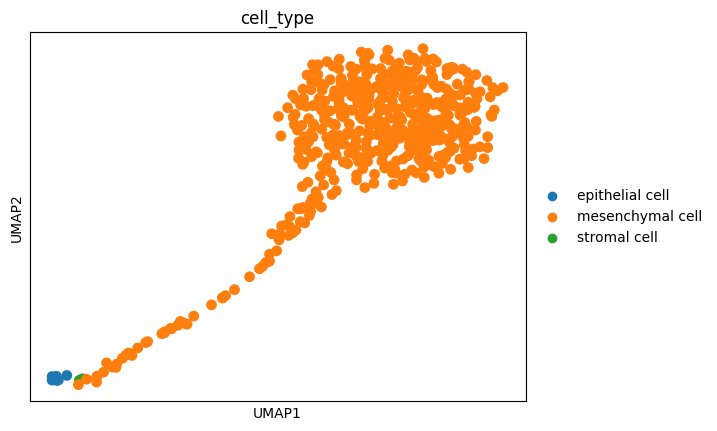

In [128]:
adata.obs['cell_type'] = adata.obs.index    
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color='cell_type')

In [65]:
# generation template
for j in range(1):
    all_labeled_synthetics = pd.DataFrame()
    synthetic_samples = [gen_sample(gene_profiles, sigma=.1) for _ in range(500)]
    for i, sample in enumerate(synthetic_samples):
        label = gen_label_by_distance(gene_profiles, sample, gene_profiles.index)
        labeled_sample = pd.DataFrame([sample], columns = gene_profiles.columns)
        labeled_sample['cell_type'] = label
        all_labeled_synthetics = pd.concat([all_labeled_synthetics, labeled_sample], ignore_index=True)
all_labeled_synthetics


,Tcf4,Nacc2,Foxo1,Irf8,Foxa2,Klf4,Runx3,Nr4a1,Peg3,Nfix,...,Maf,Mnx1,Ets1,Atf3,Sox9,Nr2f2,Trp63,Tcf7,Csrnp1,cell_type
0,2.583430,3.435097,3.039094,4.155399,4.294588,5.783965,-0.085073,6.677736,-0.037732,3.683880,...,0.950819,0.333228,0.765917,7.498382,5.013078,2.931078,0.043761,1.646224,3.520986,large intestine goblet cell
1,2.548222,3.503122,3.314016,4.195526,4.098130,5.703349,0.155923,6.878261,0.130532,3.505574,...,0.851475,1.521960,0.315762,7.116257,4.801707,3.529918,0.223524,1.262963,3.369338,large intestine goblet cell
2,2.735611,3.602106,3.225567,3.932658,4.098036,5.977408,0.276505,6.628621,0.086983,3.555586,...,0.740454,1.037388,0.878911,7.114597,5.292826,3.060513,0.423394,1.091826,3.868354,large intestine goblet cell
3,2.805006,3.502939,2.881317,3.875995,4.063991,5.672114,0.087008,6.218967,0.317197,3.254905,...,0.634000,0.877484,1.125231,6.988583,4.685231,3.207411,0.004510,1.223163,3.305174,large intestine goblet cell
4,2.584647,3.235691,3.253983,3.895438,4.273795,5.850855,0.064534,6.414932,0.161240,3.617181,...,1.056628,0.526236,0.820499,7.332831,5.084624,2.569318,-0.167572,1.399381,3.303148,large intestine goblet cell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2.554115,2.870562,3.301850,2.985490,2.125678,4.077182,0.209394,4.552854,0.708409,2.497656,...,1.637400,0.364938,1.724472,4.923991,3.025636,2.264533,-0.188377,0.973686,2.483958,enterocyte of epithelium of large intestine
496,2.809947,2.934207,3.698450,4.694052,4.127021,5.631695,-0.305481,6.774381,0.074257,3.361725,...,0.970141,0.902153,0.858001,7.152264,5.209655,3.419245,-0.212686,1.542012,3.479242,large intestine goblet cell
497,2.755096,2.856592,3.159234,3.805449,3.632001,5.532539,-0.200277,6.124648,0.179627,3.118578,...,1.282897,0.605791,0.881034,6.581475,4.218497,3.099942,0.063977,1.103672,2.917654,large intestine goblet cell
498,2.796825,3.485992,2.851298,4.523014,4.017051,5.750447,-0.099363,6.737482,-0.054492,3.605223,...,1.180672,1.508072,0.662802,7.110866,4.683447,2.621849,0.029151,1.167630,3.269646,large intestine goblet cell


### Generating large intestine and liver cells

In [69]:
for j in range(20):
    all_labeled_synthetics_2 = pd.DataFrame()
    synthetic_samples = [gen_sample(gene_profiles, sigma=.3) for _ in range(500)]
    for i, sample in enumerate(synthetic_samples):
        label = gen_label_by_distance(gene_profiles, sample, gene_profiles.index)
        labeled_sample = pd.DataFrame([sample], columns = gene_profiles.columns)
        labeled_sample['cell_type'] = label
        all_labeled_synthetics_2 = pd.concat([all_labeled_synthetics_2, labeled_sample], ignore_index=True)
    all_labeled_synthetics_2.to_csv(f"synthetic_large_intestine_and_liver_cells{j}.csv") 
# print(all_labeled_synthetics_2["cell_type"].value_counts())
# all_labeled_synthetics_2

In [67]:
all_labeled_synthetics["cell_type"].value_counts()

cell_type
large intestine goblet cell                    459
epithelial cell of large intestine              22
enterocyte of epithelium of large intestine     19
Name: count, dtype: int64

### Generating pancreatic cells

In [80]:
# gene_profiles

In [79]:
pancreatic_cells = [
    "pancreatic A cell",
    "type B pancreatic cell",
    "pancreatic acinar cell",
    "pancreatic PP cell",
    "pancreatic ductal cell",
    "pancreatic D cell",
    "pancreatic stellate cell"
]
pancreatic_gene_profiles = gene_profiles.loc[pancreatic_cells]

In [81]:
for j in range(1):
    synthetic_samples = [gen_sample(pancreatic_gene_profiles, sigma=.3) for _ in range(500)]
    labels = [gen_label_by_distance(pancreatic_gene_profiles, sample, pancreatic_gene_profiles.index) for sample in synthetic_samples]
    labeled_samples = pd.DataFrame(synthetic_samples, columns = pancreatic_gene_profiles.columns)
    labeled_samples['cell_type'] = labels
    labeled_samples.to_csv(f"pancreatic/synthetic_pancreatic_cells{j}.csv")

In [84]:
labeled_samples["cell_type"].value_counts()

cell_type
pancreatic stellate cell    469
pancreatic PP cell           31
Name: count, dtype: int64

## generating brain cells

In [85]:
skin_cells = [
    "epidermal cell",
    "keratinocyte stem cell",
    "basal cell of epidermis",
    "stem cell of epidermis",
    "keratinocyte"
]
skin_gene_profiles = gene_profiles.loc[skin_cells]

In [86]:
for j in range(1):
    synthetic_samples = [gen_sample(skin_gene_profiles, sigma=.3) for _ in range(500)]
    labels = [gen_label_by_distance(skin_gene_profiles, sample, skin_gene_profiles.index) for sample in synthetic_samples]
    labeled_samples = pd.DataFrame(synthetic_samples, columns = skin_gene_profiles.columns)
    labeled_samples['cell_type'] = labels
    # labeled_samples.to_csv(f"pancreatic/synthetic_pancreatic_cells{j}.csv")

In [87]:
labeled_samples["cell_type"].value_counts()

cell_type
basal cell of epidermis    500
Name: count, dtype: int64

In [89]:
brain_cells = [
    "astrocyte",
    "oligodendrocyte",
    "neuron",
    "oligodendrocyte precursor cell",
    "Bergmann glial cell",
    "brain pericyte",
    "microglial cell"
]
brain_gene_profiles = gene_profiles.loc[brain_cells]

synthetic_samples = [gen_sample(brain_gene_profiles, sigma=.3) for _ in range(500)]
labels = [gen_label_by_distance(brain_gene_profiles, sample, brain_gene_profiles.index) for sample in synthetic_samples]
labeled_samples = pd.DataFrame(synthetic_samples, columns = brain_gene_profiles.columns)
labeled_samples['cell_type'] = labels

labeled_samples["cell_type"].value_counts()

cell_type
brain pericyte    477
astrocyte          23
Name: count, dtype: int64

# Clustering

In [90]:
import scanpy as sc
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering

In [117]:
kmeans = KMeans(n_clusters=3)
spectral = SpectralClustering(n_clusters=3)

In [118]:
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

In [129]:
# Clustering the synthetic data and calculating silhouette score
kmeans_score_full = 0
kmeans_score_umap = 0
kmeans_score_pca = 0
kmeans_score_tsne = 0

spectral_score_umap = 0
spectral_score_pca = 0
spectral_score_tsne = 0

for i in range(20):
    data = pd.read_csv(f"large_intestine_synthetic_data/synthetic_large_intestine_and_liver_cells{i}.csv").set_index("cell_type")    
    adata = sc.AnnData(data)

    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.tl.pca(adata)
    sc.tl.tsne(adata)

    # cluster the data
    adata.obs["kmeans_full"] = kmeans.fit_predict(adata.X) 
    adata.obs["kmeans_umap"] = kmeans.fit_predict(adata.obsm["X_umap"])
    adata.obs["kmeans_pca"] = kmeans.fit_predict(adata.obsm["X_pca"][:, :3])
    adata.obs["kmeans_tsne"] = kmeans.fit_predict(adata.obsm["X_tsne"])

    # calculate silhouette score
    kmeans_score_full += silhouette_score(adata.X, adata.obs["kmeans_full"])
    kmeans_score_umap += silhouette_score(adata.obsm["X_umap"], adata.obs["kmeans_umap"]) 
    kmeans_score_pca += silhouette_score(adata.obsm["X_pca"][:, :3], adata.obs["kmeans_pca"])
    kmeans_score_tsne += silhouette_score(adata.obsm["X_tsne"], adata.obs["kmeans_tsne"])

    # cluster the data
    adata.obs["spectral_umap"] = spectral.fit_predict(adata.obsm["X_umap"])
    adata.obs["spectral_pca"] = spectral.fit_predict(adata.obsm["X_pca"][:, :3])
    adata.obs["spectral_tsne"] = spectral.fit_predict(adata.obsm["X_tsne"])

    # calculate silhouette score
    spectral_score_umap += silhouette_score(adata.obsm["X_umap"], adata.obs["spectral_umap"]) 
    spectral_score_pca += silhouette_score(adata.obsm["X_pca"][:, :3], adata.obs["spectral_pca"])
    spectral_score_tsne += silhouette_score(adata.obsm["X_tsne"], adata.obs["spectral_tsne"])

print(f"average silhouette score for kmeans full: {kmeans_score_full/20}")
print(f"average silhouette score for kmeans umap: {kmeans_score_umap/20}")
print(f"average silhouette score for kmeans pca: {kmeans_score_pca/20}")
print(f"average silhouette score for kmeans tsne: {kmeans_score_tsne/20}")


print(f"average silhouette score for spectral umap: {spectral_score_umap/20}")
print(f"average silhouette score for spectral pca: {spectral_score_pca/20}")
print(f"average silhouette score for spectral tsne: {spectral_score_tsne/20}")

In [ ]:
kmeans_score_full = 0
kmeans_score_umap = 0
kmeans_score_pca = 0
kmeans_score_tsne = 0

spectral_score_umap = 0
spectral_score_pca = 0
spectral_score_tsne = 0

for i in range(20):
    data = pd.read_csv(f"large_intestine_synthetic_data/synthetic_large_intestine_and_liver_cells{i}.csv").set_index("cell_type")    
    adata = sc.AnnData(data)

    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.tl.pca(adata)
    sc.tl.tsne(adata)

    # cluster the data
    adata.obs["kmeans_full"] = kmeans.fit_predict(adata.X) 
    adata.obs["kmeans_umap"] = kmeans.fit_predict(adata.obsm["X_umap"])
    adata.obs["kmeans_pca"] = kmeans.fit_predict(adata.obsm["X_pca"][:, :3])
    adata.obs["kmeans_tsne"] = kmeans.fit_predict(adata.obsm["X_tsne"])

    # calculate silhouette score
    kmeans_score_full += silhouette_score(adata.X, adata.obs["kmeans_full"])
    kmeans_score_umap += silhouette_score(adata.obsm["X_umap"], adata.obs["kmeans_umap"]) 
    kmeans_score_pca += silhouette_score(adata.obsm["X_pca"][:, :3], adata.obs["kmeans_pca"])
    kmeans_score_tsne += silhouette_score(adata.obsm["X_tsne"], adata.obs["kmeans_tsne"])

    # cluster the data
    adata.obs["spectral_umap"] = spectral.fit_predict(adata.obsm["X_umap"])
    adata.obs["spectral_pca"] = spectral.fit_predict(adata.obsm["X_pca"][:, :3])
    adata.obs["spectral_tsne"] = spectral.fit_predict(adata.obsm["X_tsne"])

    # calculate silhouette score
    spectral_score_umap += silhouette_score(adata.obsm["X_umap"], adata.obs["spectral_umap"]) 
    spectral_score_pca += silhouette_score(adata.obsm["X_pca"][:, :3], adata.obs["spectral_pca"])
    spectral_score_tsne += silhouette_score(adata.obsm["X_tsne"], adata.obs["spectral_tsne"])

print(f"average silhouette score for kmeans full: {kmeans_score_full/20}")
print(f"average silhouette score for kmeans umap: {kmeans_score_umap/20}")
print(f"average silhouette score for kmeans pca: {kmeans_score_pca/20}")
print(f"average silhouette score for kmeans tsne: {kmeans_score_tsne/20}")


print(f"average silhouette score for spectral umap: {spectral_score_umap/20}")
print(f"average silhouette score for spectral pca: {spectral_score_pca/20}")
print(f"average silhouette score for spectral tsne: {spectral_score_tsne/20}")

In [114]:
spectral_score_umap = 0
spectral_score_pca = 0
spectral_score_tsne = 0

for i in range(20):
    data = pd.read_csv(f"large_intestine_synthetic_data/synthetic_large_intestine_and_liver_cells{i}.csv").set_index("cell_type")    
    adata = sc.AnnData(data)
    # adata.obs["celltype"] = adata.obs.index
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.tl.pca(adata)
    sc.tl.tsne(adata)

    # cluster the data
    adata.obs["spectral_umap"] = spectral.fit_predict(adata.obsm["X_umap"])
    adata.obs["spectral_pca"] = spectral.fit_predict(adata.obsm["X_pca"][:, :3])
    adata.obs["spectral_tsne"] = spectral.fit_predict(adata.obsm["X_tsne"])

    # calculate silhouette score
    spectral_score_umap += silhouette_score(adata.obsm["X_umap"], adata.obs["spectral_umap"]) 
    spectral_score_pca += silhouette_score(adata.obsm["X_pca"][:, :3], adata.obs["spectral_pca"])
    spectral_score_tsne += silhouette_score(adata.obsm["X_tsne"], adata.obs["spectral_tsne"])

print(f"average silhouette score for spectral umap: {spectral_score_umap/20}")
print(f"average silhouette score for spectral pca: {spectral_score_pca/20}")
print(f"average silhouette score for spectral tsne: {spectral_score_tsne/20}")

         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Fal

In [116]:
kmeans_score_full = 0
kmeans_score_umap = 0
kmeans_score_pca = 0
kmeans_score_tsne = 0

for i in range(5):
    data = pd.read_csv(f"Synthetics/synthetic_gene_expressions{i}.csv").set_index("celltype")    
    adata = sc.AnnData(data)
    # adata.obs["celltype"] = adata.obs.index
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.tl.pca(adata)
    sc.tl.tsne(adata)

    # cluster the data
    adata.obs["kmeans_full"] = kmeans.fit_predict(adata.X) 
    adata.obs["kmeans_umap"] = kmeans.fit_predict(adata.obsm["X_umap"])
    adata.obs["kmeans_pca"] = kmeans.fit_predict(adata.obsm["X_pca"][:, :3])
    adata.obs["kmeans_tsne"] = kmeans.fit_predict(adata.obsm["X_tsne"])

    # calculate silhouette score
    kmeans_score_full += silhouette_score(adata.X, adata.obs["kmeans_full"])
    kmeans_score_umap += silhouette_score(adata.obsm["X_umap"], adata.obs["kmeans_umap"]) 
    kmeans_score_pca += silhouette_score(adata.obsm["X_pca"][:, :3], adata.obs["kmeans_pca"])
    kmeans_score_tsne += silhouette_score(adata.obsm["X_tsne"], adata.obs["kmeans_tsne"])

print(f"average silhouette score for kmeans full: {kmeans_score_full/20}")
print(f"average silhouette score for kmeans umap: {kmeans_score_umap/20}")
print(f"average silhouette score for kmeans pca: {kmeans_score_pca/20}")
print(f"average silhouette score for kmeans tsne: {kmeans_score_tsne/20}")

         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
average silhouette score for kmeans full: 0.13073528028965162
average silhouette score for kmeans umap: 0.09407866895198821
average silhouette score for kmeans pca: 0.1963230550289154
average silhouette score for kmeans tsne: 0.10259286314249039


In [123]:
adata.obs["celltype"] = adata.obs.index

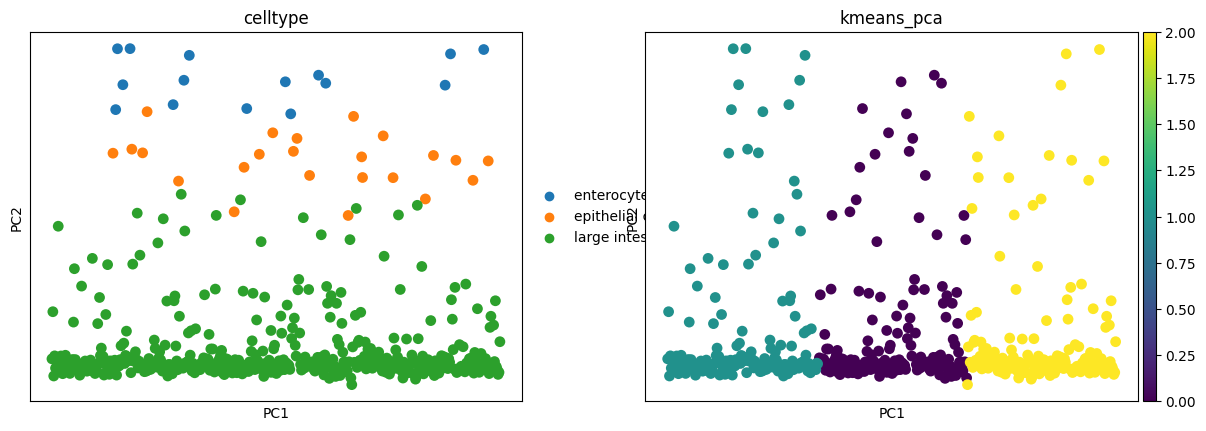

In [104]:
sc.pl.pca(adata, color=["celltype", "kmeans_pca"])

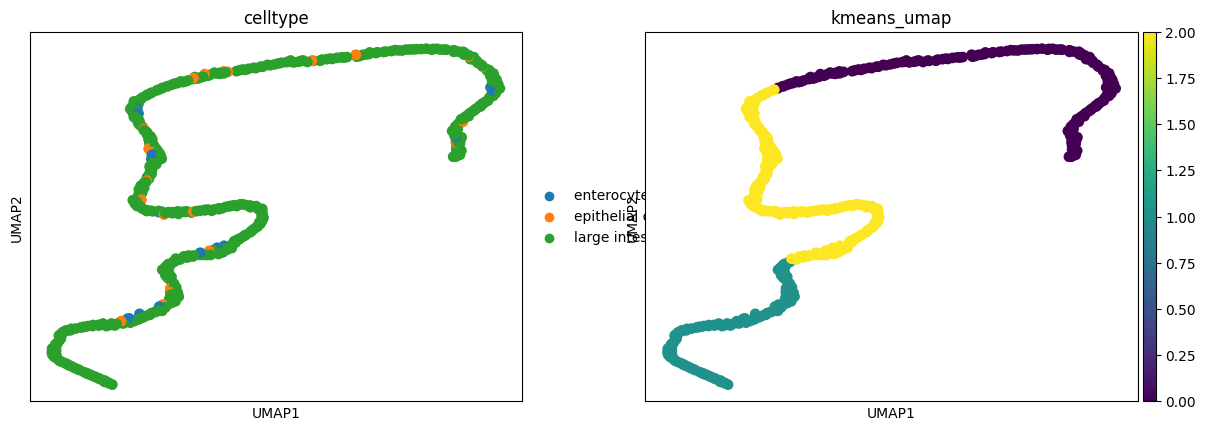

In [108]:
sc.pl.umap(adata, color=["celltype", "kmeans_umap"])

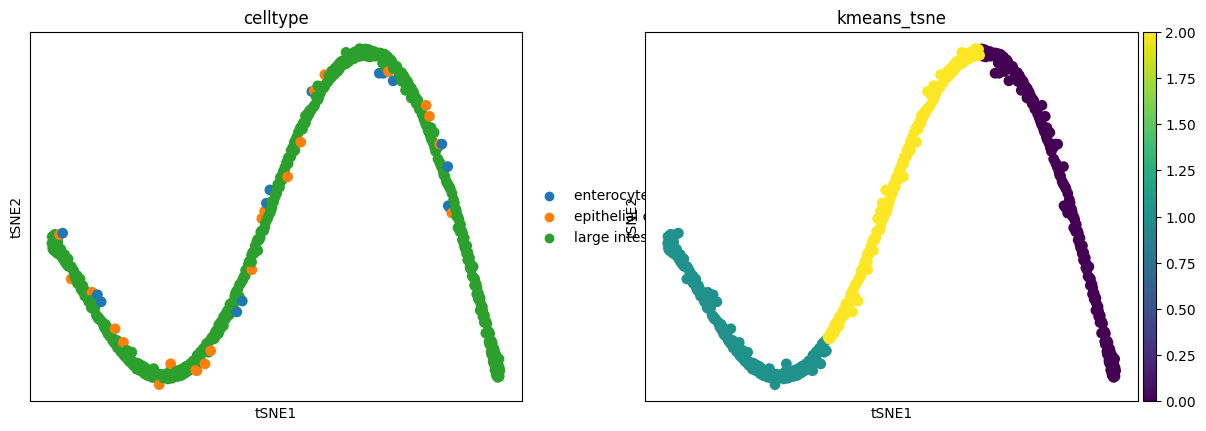

In [124]:
sc.pl.tsne(adata, color=["celltype", "kmeans_tsne"])